In [ ]:
#my info here
__author__ = "Tomo Shimo"
__email__ = "tomo.krmr@gmail.com"

In [1]:
#import the libraries we use
import pandas as pd
import sklearn as sk
import numpy as np

In [5]:
import os

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
from sklearn.pipeline import make_pipeline

In [129]:
import time

In [131]:
from sklearn.model_selection import GridSearchCV

In [36]:
# some function for data loading

def load_data(path, filename):
    filepath = os.path.join(path, filename)
    return pd.read_csv(filepath)

def check_df(df):
    # NaN 
    print('# of NaN')
    print(df.isna().sum())
    # Duplicate
    print('\n # of Duplicate')
    print(df.duplicated().sum())

In [87]:
# some function for EDA

def cat_boxplot(df, target, feature):
    df_feature_mean = df.groupby([feature],as_index=False).mean()
    df_feature_sorted = df_feature_mean.sort_values(by=target)
    plt.figure()
    sns.boxplot(x=feature, y=target, data=df, order=df_feature_sorted[feature].values)
    plt.xticks(rotation=45)

In [103]:
# some function for Modeling

def cv_5(model, features, target):
    # 5-fold cross validation
    Rcross = sk.model_selection.cross_val_score(model,features,target, cv=5, scoring='neg_mean_squared_error')
    print(model)
    print('Mean: '+str(- Rcross.mean())+', Std: '+str(Rcross.std()))

## ---- 1 Define the problem ----

This is the salary prediction project; we predict the salary based on the job descriptions. We are going to make a model. If we obtain a new job description, we can predict the salary for this new job with using this model.

## ---- 2 Load the data ----

In [13]:
csv_path = '~/Documents/Study/DSDJ/Instructions_and_Notebook/data/'
df_features = load_data(csv_path, 'train_features.csv')

In [8]:
df_features.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [14]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [11]:
df_salaries = load_data(csv_path, 'train_salaries.csv')

In [12]:
df_salaries.head(10)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [15]:
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


If we find the mismatch between data type and actual data, we'll modify it here.

## ---- 3 Clean the data ---
We look for duplicate data, invalid data, or corrupt data and remove it

In [37]:
check_df(df_features)

# of NaN
jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

 # of Duplicate
0


In [38]:
check_df(df_salaries)

# of NaN
jobId     0
salary    0
dtype: int64

 # of Duplicate
0


Here, salaries <= 0 are invalid.

In [39]:
df_salaries.query('salary <= 0')

,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


In [40]:
df_salaries_mod = df_salaries.query('salary > 0')

Here, we marge features dataframe and salary dataframe.
JobId is the index for these data.

In [41]:
df = pd.merge(df_salaries_mod, df_features, how="inner" ,on="jobId")

## ---- 4 Explore the data (EDA) ----

In [74]:
# Before starting EDA, we are going to set some useful variables.
# num_features: features have numerical value
# cat_features: features have categorical value
# target: target value

num_features = ['yearsExperience', 'milesFromMetropolis']
cat_features = ['companyId', 'jobType', 'degree', 'major', 'industry']
target = 'salary'

### Numerical features

In [43]:
df.describe()

,salary,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000,999995.000000
mean,116.062398,11.992407,49.529381
std,38.717163,7.212390,28.877721
min,17.000000,0.000000,0.000000
25%,88.000000,6.000000,25.000000
50%,114.000000,12.000000,50.000000
75%,141.000000,18.000000,75.000000
max,301.000000,24.000000,99.000000


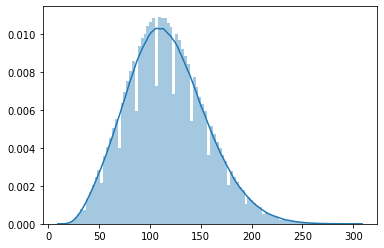

In [46]:
# See how is the distribution of target value
sns.distplot(df[target], 100,"salary", "Distribution of salary")

We can see a long tail on the right side but it looks like a regular distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa21367ad0>,
      dtype=object)

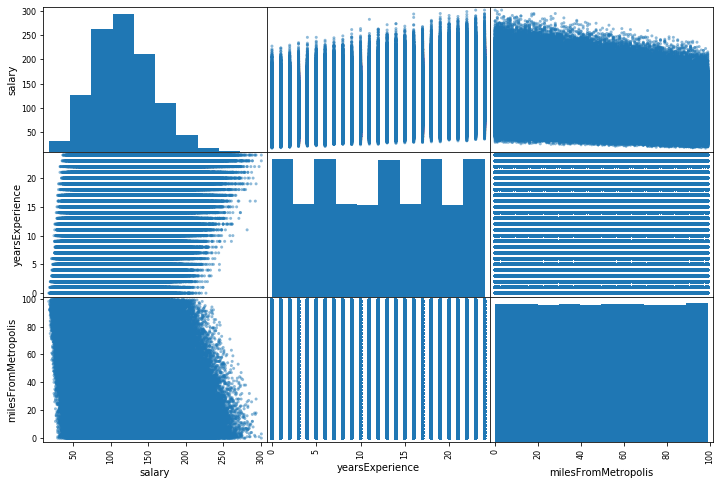

In [57]:
# See how is the correlation between target and numerical features
from pandas.plotting import scatter_matrix
attributes = target[:]
attributes.extend(num_features)
scatter_matrix(df[attributes], figsize=(12,8))

In [58]:
df.corr()

,salary,yearsExperience,milesFromMetropolis
salary,1.000000,0.375013,-0.297686
yearsExperience,0.375013,1.000000,0.000672
milesFromMetropolis,-0.297686,0.000672,1.000000


From these analyses, salary is **positively correlated** with years of experience and **negatively correlated** with miles from metropolis.

### Categorical features
Next, we are going to see how the categorical features affect to the salary.

In [94]:
df.describe(include='O') # 'O' means Object

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684566069,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


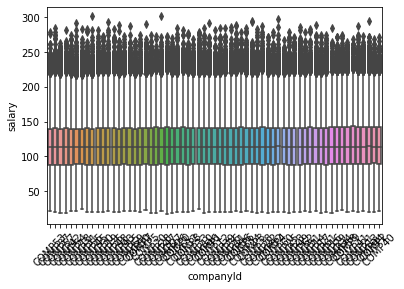

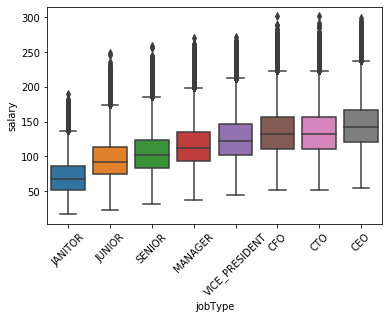

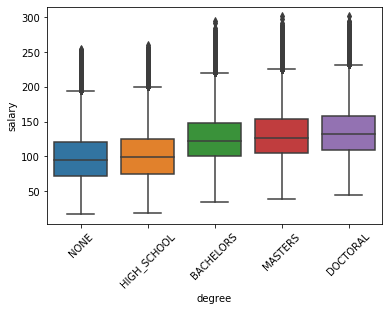

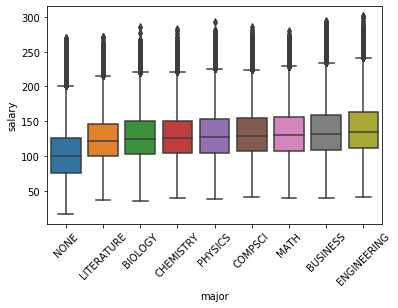

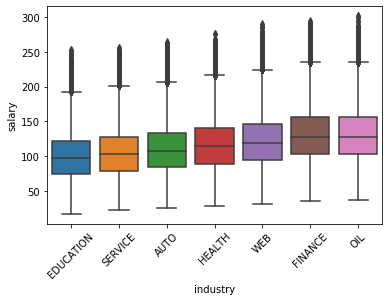

In [89]:
for feature in cat_features:
    cat_boxplot(df, target, feature)

From these analyses, salary is **correlated** with jobType, degree, major and industry, but looks like there's **little** correlation with companyId.

## ---- 5 Establish a baseline ---
Aiming MSE < 360  
At first, the salary considered to have a linear relationship with the years of experience.

In [96]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(df[['yearsExperience']],df['salary'])
print( "Salary = " + str(lm.coef_[0]) + " * yearsExperience + " + str(lm.intercept_))

Salary = 2.013126778161152 * yearsExperience + 91.92016272211305


In [104]:
cv_5(lm,df[['yearsExperience']],df['salary'] )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Mean: 1288.2115798018679, Std: 4.4471005278617515


The MSE (Mean Squared Error) is 1288.

## ---- 6 Hypothesize solution ----

## ---- 7 Engineer features  ----

Here, we use all the features without companyId.

In [112]:
cat_features.remove('companyId')

In [113]:
cat_features

['jobType', 'degree', 'major', 'industry']

In [114]:
# Transform categorical features into one-hot valiables

df_num = df[num_features]
df_cat = df[cat_features]
df_ = df_num.join(pd.get_dummies(df_cat))

In [115]:
df_

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,8,17,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999990,19,94,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
999991,12,35,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
999992,16,81,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
999993,6,5,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


## ---- 8 Create models ----
We are using linear regression, random forest regression and gradient boosting.

### Linear Regression

In [116]:
lr = LinearRegression()
lr.fit(df_,df[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [117]:
cv_5(lr,df_,df[target] )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Mean: 384.414330364542, Std: 1.7820224990851443


### RandomForest

In [126]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
cv_5(forest_reg,df_,df[target] )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs


/Users/tomokrmr/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/tomokrmr/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/tomokrmr/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/tomokrmr/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/tomokrmr/

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Mean: 466.6618164118239, Std: 1.5020576715505762


In [134]:
start = time.time()
param_grid = [
    {'n_estimators': [10,30, 100]}
]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(df_, df[target])
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
grid_search.best_params_

elapsed_time:3555.1813366413116[sec]


{'n_estimators': 100}

In [137]:
start = time.time()
forest_reg = RandomForestRegressor(n_estimators=150, n_jobs=-1)
cv_5(forest_reg,df_,df[target] )
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
Mean: 441.4249736579786, Std: 1.473605000700608
elapsed_time:1249.712408065796[sec]


### Gradient Boosting

In [128]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor()
cv_5(gb_reg,df_,df[target] )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Mean: 375.5730153907617, Std: 1.824621140967937


In [132]:
start = time.time()
param_grid = [
    {'n_estimators': [30, 100]}
]
grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(df_, df[target])
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:827.5315928459167[sec]


In [133]:
grid_search.best_params_

{'n_estimators': 100}

In [138]:
start = time.time()
gb_reg = GradientBoostingRegressor(n_estimators=200)
cv_5(gb_reg,df_,df[target] )
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Mean: 359.39704233355366, Std: 1.4427514634848015
elapsed_time:1170.336642742157[sec]


In [142]:
start = time.time()
gb_reg = GradientBoostingRegressor(n_estimators=1000)
cv_5(gb_reg,df_,df[target] )
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Mean: 355.12422968465734, Std: 1.4534144544422762
elapsed_time:6150.998552799225[sec]


In [144]:
# Plot feature importance
gb_reg_200 = GradientBoostingRegressor(n_estimators=200)
gb_reg_200.fit(df_,df[target] )
feature_importance = gb_reg_200.feature_importances_

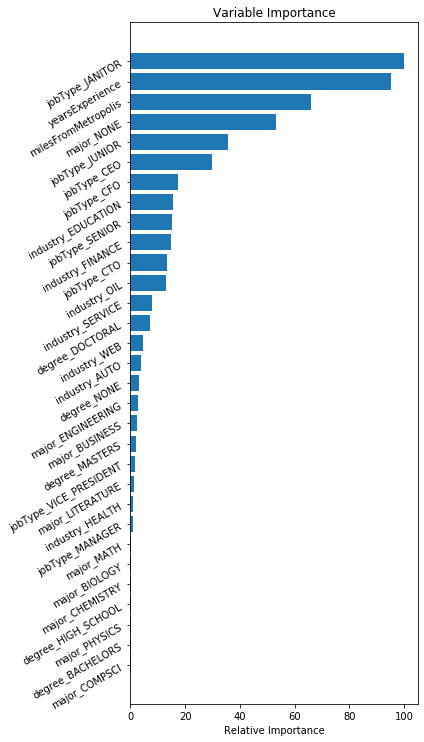

In [156]:
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(6, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_.columns[sorted_idx], rotation=30)
plt.tight_layout()
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## ---- 9 Test models ----

## ---- 10 Select best model  ----